In [270]:
#importing pandas module for data manupilation 
import pandas as pd

#importing numpy module
import numpy as np

#reading imu data
imu=pd.read_table('imu_data.txt',sep='\s+')

#reading gps data
gps=pd.read_table('gps_data.txt', sep='\s+')

In [271]:
imu1={}
    #downsampling the imu data 
for i in range(0,len(imu['Time']),100): 
    imu1[i/100] = (imu.iloc[i])
    
    
imu1=pd.DataFrame(imu1)
    
imu=imu1.T
n=len(imu['Time'])-1
n

39

In [272]:
print imu.columns
print gps.columns

Index([u'Time', u'IMU_X_ACC', u'IMU_Y_ACC', u'IMU_Z_ACC', u'IMU_YAW_VEL',
       u'IMU_PITCH_VEL', u'IMU_ROLL_VEL', u'IMU_X_VEL', u'IMU_Y_VEL',
       u'IMU_Z_VEL', u'IMU_YAW', u'IMU_PITCH', u'IMU_ROLL', u'IMU_X', u'IMU_Y',
       u'IMU_Z'],
      dtype='object')
Index([u'Time', u'Lat', u'Lon', u'Alt', u'fix', u'#sats', u'speed', u'dir',
       u'Local_X', u'Local_Y', u'Local_Z', u'rawlog_ID', u'Geocen_X',
       u'Geocen_Y', u'Geocen_Z', u'GPS_X', u'GPS_Y', u'GPS_Z', u'GPS_VX',
       u'GPS_VY', u'GPS_VZ', u'Local_VX', u'Local_VY', u'Local_VZ',
       u'SAT_Time'],
      dtype='object')


In [277]:
#putting dt = sampling time eqaul to 1
dt=1

In [278]:
#defining matrix A(state transition matrix)

A=np.matrix([[1,dt,-0.5*dt**2,0,0,0,0,0,0],
            [0,1,-dt,0,0,0,0,0,0],
            [0,0,1,0,0,0,0,0,0],
            [0,0,0,1,dt,-0.5*dt**2,0,0,0],
            [0,0,0,0,1,-dt,0,0,0],
            [0,0,0,0,0,1,0,0,0],
            [0,0,0,0,0,0,1,dt,-0.5*dt**2],
            [0,0,0,0,0,0,0,1,-dt],
            [0,0,0,0,0,0,0,0,1]])
A

matrix([[ 1. ,  1. , -0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  1. , -1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  1. ,  1. , -0.5,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  1. , -1. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  1. , -0.5],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. , -1. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ]])

In [279]:



#B is input/ control matrix 

B=np.matrix([[0.5*dt**2,0,0],
            [dt,0,0],
            [1,0,0],
            [0,0.5*dt**2,0],
            [0,dt,0],
            [0,1,0],
            [0,0,0.5*dt**2],
            [0,0,dt],
            [0,0,1]])
B          

matrix([[ 0.5,  0. ,  0. ],
        [ 1. ,  0. ,  0. ],
        [ 1. ,  0. ,  0. ],
        [ 0. ,  0.5,  0. ],
        [ 0. ,  1. ,  0. ],
        [ 0. ,  1. ,  0. ],
        [ 0. ,  0. ,  0.5],
        [ 0. ,  0. ,  1. ],
        [ 0. ,  0. ,  1. ]])

In [43]:
#H is measurement matrix

H=np.matrix(np.diag([1,0,0,1,0,0,1,0,0]))
H

matrix([[1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [280]:


def Um(imu, i):
    acc_x=imu['IMU_X_ACC'][i]
    acc_y=imu['IMU_Y_ACC'][i]
    acc_z=imu['IMU_Z_ACC'][i]
    U_mat=np.matrix([[acc_x],
                    [acc_y],
                    [acc_z]])
    return U_mat



In [281]:

#previous_velocity list

prev_vel=[[0,0,0]]

#acceration baises
abx=0
aby=0
abz=-(np.array(imu['IMU_Z_ACC']).mean())


#defining a function that will return linear velocity using angular velocities and accelerations
#prev_vel is dict that contains previous velocities with i as keys 
#this will predict velocity for nex time step using velocities of previous time step
def vel(imu,prev_vel,i):
    pvel=np.matrix([prev_vel[i][0],
                    prev_vel[i][1],
                    prev_vel[i][2]])
    pvel=pvel.T
    #making a 3x3 matrix using roll yaw and pitch
    p=imu['IMU_PITCH_VEL'][i]
    q=imu['IMU_ROLL_VEL'][i]
    r=imu['IMU_YAW_VEL'][i]
    #ang_mat=angualr rate matrix
    ang_mat=np.matrix([[0,r,-q],
                     [-r,0,p],
                     [-p,q,0]])
    #acc_matrix is linear acc matux that consists of imu data from imu acc
    acc_mat=np.matrix([[imu['IMU_X_ACC'][i]],
                     [imu['IMU_Y_ACC'][i]],
                     [imu['IMU_Z_ACC'][i]]])
    bias_acc=np.matrix([[abx],
                       [aby],
                       [abz]])
    #calculating new velocity 
    new_vel=(pvel+(ang_mat*pvel)*dt+acc_mat*dt+bias_acc*dt).T
    return np.ravel(new_vel)


In [282]:
Xhat=np.array([[0,0,abx,0,0,aby,0,0,abz]])

def Xm(Xhat,i,vx,vy,vz):
    xk=Xhat[i][0]
    yk=Xhat[i][3]
    zk=Xhat[i][6]
    vxk=vx
    vyk=vy
    vzk=vz
    
    X=np.matrix([xk,vxk,abx,yk,vyk,aby,zk,vzk,abz]) #############
    X=np.transpose(X) ###############
    return X

Xm(Xhat,0,1,1,1)

matrix([[ 0.        ],
        [ 1.        ],
        [ 0.        ],
        [ 0.        ],
        [ 1.        ],
        [ 0.        ],
        [ 0.        ],
        [ 1.        ],
        [-9.74434586]])

In [283]:
#Y is measured gps values

def Ym(gps,i):
    yxk1=gps['Local_X'][i+1]
    yyk1=gps['Local_Y'][i+1]
    yzk1=gps['Local_Z'][i+1]

    Y=np.matrix([[yxk1],[0], [0], [yyk1], [0], [0], [yzk1],[0],[0]])
    
    return Y
Ym(gps,2).shape


(9, 1)

In [298]:

P=np.matrix(np.diag([9,0.01,0.01,9,0.01,0.01,9,0.01,0.01]))
P.shape


(9, 9)

In [299]:

Q=np.matrix(np.eye(9,9))*0.33
Q

matrix([[ 0.33,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.33,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.33,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.33,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.33,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.33,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.33,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.33,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.33]])

In [300]:
#R=np.matrix(np.zeros((9,9)))
#R

In [301]:
R = np.matrix(np.eye(9,9))*0.33
R


matrix([[ 0.33,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.33,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.33,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.33,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.33,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.33,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.33,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.33,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.33]])

In [302]:
#Q = np.matrix(np.eye(np.shape(X)[0]))
#Q

In [303]:
from numpy import dot, sum, tile, linalg 
from numpy.linalg import inv

def kf_update (X, P, Y, H, R):  
    IM = H*X    
    IS = R + H*(P*H.T) 
    K = (P*(H.T*inv(IS)))  
    X = X + (K*(Y-IM))   
    P = P - (K*(IS*K.T))  
    return (X,P,K,IM,IS)
    

In [304]:
def kf_predict (X, P, A, Q, B, U):  
    X =  A*X + B*U
    P = A*(P *A.T) + Q 
    return(X,P) 

In [305]:
#applying kalman filter 
#iterartion and calling various variables 
#defining each arrays for each variable new changed---X,Velocity,P,k

Xhat=[[0,0,abx,0,0,aby,0,0,abz]]
Pminus=P
prev_vel=[[0,0,0],]
#for i in range (len(imu['IMU_Z_ACC'])): 
for i in range (n):
    #velocity calculation
    new_vel=vel(imu,prev_vel,i)
    prev_vel.append(new_vel)
    vx=new_vel[0]
    vy=new_vel[1]
    vz=new_vel[2]
    
    #getting values for all variables to be used
    X=Xm(Xhat,i,vx,vy,vz)
    P=Pminus
    Y=Ym(gps,i)
    U=Um(imu, i)
    (X, P) = kf_predict(X, P, A, Q, B, U)   
    (X, P, K, IM, IS) = kf_update(X, P, Y, H, R) 
    
    Xhat.append((np.ravel(X)))
    Pminus=P
    
    
    

In [306]:
Xhat

[[0, 0, 0, 0, 0, 0, 0, 0, -9.7443458557128899],
 array([  1.58707284,   0.19691839,   0.09653102,   3.42044301,
          0.61614808,   0.3041111 ,   3.59441709,  19.04547697,  -0.21381431]),
 array([  1.69344227,   0.26644459,   0.16243342,   5.15197986,
          1.58013038,   0.33297019,   5.93855444,  16.01068394,   1.42997351]),
 array([  1.88720813,   0.53055477,   0.62439338,   7.40400304,
          2.09021518,  -0.22902201,   5.91493702,  12.0438383 ,   3.84252665]),
 array([  2.13892248,   0.35853108,   0.23724126,  10.0599045 ,
          2.69009293,   0.01278953,   5.80022609,  10.96051853,   3.155017  ]),
 array([  2.51825477,   0.22221045,  -0.32435685,  12.69329338,
          2.69063038,   0.04895935,   6.17580381,  11.36646639,   3.27443446]),
 array([  2.65608545,  -0.04735712,  -0.391982  ,  15.25768479,
          2.36903413,  -0.49042653,   6.65639053,  11.48819802,   3.42315846]),
 array([  2.84199633,   0.29745473,   0.23473244,  18.05088588,
          2.79248603,  -

In [307]:
xdir={}
for i in range(n):
    xdir[i]=(Xhat[i][0])
    
xdir

{0: 0,
 1: 1.5870728376822867,
 2: 1.6934422739282353,
 3: 1.887208125936918,
 4: 2.1389224806632749,
 5: 2.5182547694978017,
 6: 2.6560854459853984,
 7: 2.8419963256826368,
 8: 3.3261241290093801,
 9: 3.7516491904506286,
 10: 3.8435515001969449,
 11: 4.2690961581288773,
 12: 4.5349010782746042,
 13: 4.7992548148800322,
 14: 5.1003367360583933,
 15: 5.3518226974219951,
 16: 5.6025692712639286,
 17: 6.0427000802054085,
 18: 6.5830143070556026,
 19: 7.1103931595237597,
 20: 7.6644447047822002,
 21: 7.9968967765710408,
 22: 8.2788902059352001,
 23: 8.4990376781968102,
 24: 8.6893975878529819,
 25: 8.9685608238093639,
 26: 9.1559521274769224,
 27: 9.3010840325914703,
 28: 9.4518486275665996,
 29: 9.5389072767885388,
 30: 9.8687766793714005,
 31: 10.033393458190357,
 32: 10.386839479258118,
 33: 10.558648312469645,
 34: 10.711224243057348,
 35: 10.951457513190503,
 36: 11.088428591518117,
 37: 11.264471643989829,
 38: 11.280132478444466}

In [308]:
ydir={}
for i in range(n):
    ydir[i]=(Xhat[i][3])
    
ydir

{0: 0,
 1: 3.4204430085753477,
 2: 5.1519798553544627,
 3: 7.4040030419153897,
 4: 10.059904502800315,
 5: 12.693293378815484,
 6: 15.257684794479021,
 7: 18.050885881889052,
 8: 21.149778953745997,
 9: 24.290260156541589,
 10: 27.526551433741432,
 11: 30.729566014906634,
 12: 33.372008780776589,
 13: 36.310909524724408,
 14: 38.953130594873542,
 15: 41.654198159673797,
 16: 44.408570069234742,
 17: 47.271769652486149,
 18: 49.953459845407338,
 19: 52.350250380872936,
 20: 54.816577540833038,
 21: 57.406330442999824,
 22: 60.196563527335513,
 23: 63.166085124285239,
 24: 65.920799955206263,
 25: 68.903000024246538,
 26: 71.79001497494545,
 27: 74.751126105811295,
 28: 77.356238744914279,
 29: 80.186607090031103,
 30: 82.946458058300678,
 31: 86.196504981986919,
 32: 89.573534832412889,
 33: 93.148078389140409,
 34: 97.017697227882636,
 35: 100.7420686181749,
 36: 104.34477327717325,
 37: 107.72404058683249,
 38: 111.09971062670084}

In [309]:
zdir={}
for i in range(n):
    zdir[i]=(Xhat[i][6])
    
zdir

{0: 0,
 1: 3.5944170925056413,
 2: 5.9385544427485151,
 3: 5.9149370157725816,
 4: 5.8002260948818236,
 5: 6.1758038096059682,
 6: 6.6563905308333666,
 7: 7.0263173992154986,
 8: 7.1592612755004641,
 9: 7.0259629789997842,
 10: 7.2852301552937018,
 11: 6.8901287356114835,
 12: 7.0166931187151391,
 13: 6.788988956212803,
 14: 6.8927726204830488,
 15: 6.9603822888694644,
 16: 6.6964157925065422,
 17: 6.66190136076243,
 18: 6.553821503293376,
 19: 6.3680010993244043,
 20: 6.1495874010368929,
 21: 5.9917026009759944,
 22: 5.9612723648847048,
 23: 6.0984813669273787,
 24: 5.9800856510192677,
 25: 5.8799786211085063,
 26: 5.94271640712196,
 27: 5.9351100537155848,
 28: 5.9484827052791935,
 29: 5.9999272798560419,
 30: 6.0978932770337568,
 31: 6.2356557751554558,
 32: 6.2982656612756696,
 33: 6.6584109593448755,
 34: 6.746550134766867,
 35: 6.7614041233999078,
 36: 6.8677409266110043,
 37: 7.0267639468102505,
 38: 7.3037458066324739}

In [310]:
S1=pd.Series(xdir)
S2=pd.Series(ydir)
S3=pd.Series(zdir)


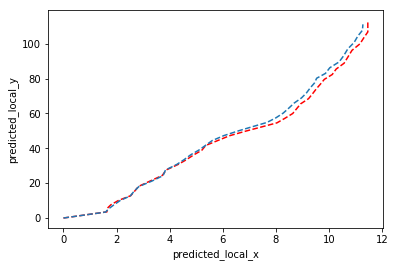

In [311]:
import matplotlib.pyplot as plt
plt.plot(gps['Local_X'][:40],gps['Local_Y'][:40],'r--',)
plt.xlabel('local_x')
plt.ylabel('local_y')
#plt.show()
plt.plot(S1[:40],S2[:40],'--')
plt.xlabel('predicted_local_x')
plt.ylabel('predicted_local_y')
plt.show()

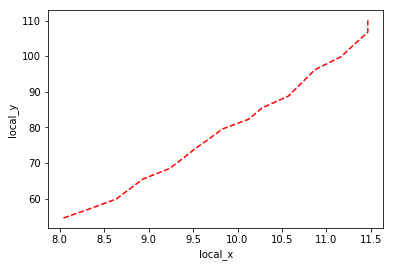

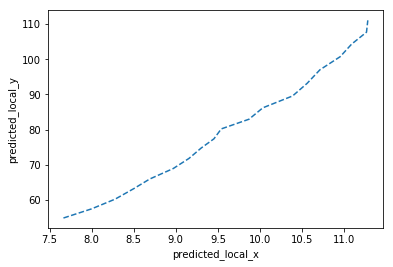

In [313]:
import matplotlib.pyplot as plt
plt.plot(gps['Local_X'][20:39],gps['Local_Y'][20:39],'r--')
plt.xlabel('local_x')
plt.ylabel('local_y')
plt.show()
plt.plot(S1[20:39],S2[20:39],'--');
plt.xlabel('predicted_local_x')
plt.ylabel('predicted_local_y')
plt.show()